# Preview the EAWAG scans
Let's see what we did there...

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client, LocalCluster
import skimage
from tqdm.auto import tqdm, trange

/home/habi/miniconda3/envs/eawag/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [3]:
# Start cluster and client now, after setting tempdir
cluster = LocalCluster()
client = Client(cluster)

In [4]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [5]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams['figure.dpi'] = 200

In [7]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [8]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)

In [9]:
# Different locations if running either on Linux or Windows
FastSSD = False
overthere = False # Load the data directly from the iee-research_storage drive
nanoct = True # Load the data directly from the 2214
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    elif overthere:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research-storage-iee')
    elif nanoct:
        BasePath = os.path.join(os.path.sep, 'home', 'habi', '2214')                
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/EAWAG/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
if not overthere:
    Root = os.path.join(BasePath, 'EAWAG')
else:
    Root = BasePath
# if overthere:
#         Root = os.path.join('I:\\microCTupload')
print('We are loading all the data from %s' % Root)

We are loading all the data from /home/habi/2214/EAWAG


In [10]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [11]:
def get_projectionsize(logfile):
    """How big did we set the camera?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Number Of Rows' in line:
                y = int(line.split('=')[1])
            if 'Number Of Columns' in line:
                x = int(line.split('=')[1])                
    return(x*y)

In [12]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [13]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [14]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [15]:
def get_reconstruction_grayvalue(logfile):
    grayvalue = None
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [16]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [17]:
def get_rotationstep(logfile):
    """Get the rotation step from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Rotation Step' in line:
                rotstep = float(line.split('=')[1])
    return(rotstep)

In [18]:
def get_frameaveraging(logfile):
    """Get the frame averaging from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Averaging' in line:
                avg = line.split('=')[1]
    return(avg)

In [19]:
def get_defectpixelmasking(logfile):
    """Check the 'defect pixel masking' setting"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'defect pixel mask' in line:
                defectmask = int(line.split('=')[1].strip())
    return(defectmask)

In [20]:
def get_machine(logfile):
    """Get the machine we used to scan"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scanner' in line:
                machine = line.split('=')[1].strip()
    return(machine)

In [21]:
def get_scantime(logfile):
    """How long did we scan?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scan duration' in line:
                time = line.split('=')[1].strip()
    return(pandas.to_timedelta(time))

In [22]:
def get_stacks(logfile):
    """How many stacks/connected scans did we make?"""
    stacks = 1
    with open(logfile, 'r') as f:
        for line in f:
            if 'conn' in line:
                stacks = int(line.split('=')[1])
    return(stacks)

In [23]:
def get_scandate(logfile, verbose=False):
    """When did we scan the fish?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Study Date and Time' in line:
                if verbose:
                    print('Found "date" line: %s' % line.strip())
                datestring = line.split('=')[1].strip().replace('  ', ' ')
                if verbose:
                    print('The date string is: %s' % datestring)
                date = pandas.to_datetime(datestring , format='%d %b %Y %Hh:%Mm:%Ss')
                if verbose:
                    print('Parsed to: %s' % date)
    return(date.isoformat())

In [24]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [25]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [26]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [27]:
# Get *all* log files
# Sort them by time, not name
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True), key=os.path.getmtime)]

In [28]:
# Data

In [29]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [30]:
# Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not 'TScopy' in row.Folder and not 'PR' in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us        
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root)+1:])

In [31]:
# 103761/proj_oj/103761.log is a scan where the sample holder touched the source

In [32]:
Data['XYAlignment'] = [glob.glob(os.path.join(f, '*.csv')) for f in Data['Folder']]

In [33]:
# Check for samples which are missing the .csv-files for the XY-alignment
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not len(row.XYAlignment):
            if not any(x in row.LogFile for x in ['rectmp.log',  # because we only exclude temporary logfiles in a later step
                                                  'proj_nofilter',  # since these two scans of single teeth don't contain a reference scan
                                                  'TScopy',  # discard *t*hermal *s*hift data
                                                  os.path.join('TJ3', 'jaw_v1'),  # no reference scan
                                                  os.path.join('28', 'full_188um'),  # no reference scan
                                                  os.path.join('75', 'proj_stuck'),  # 103375\proj_stuck which got stuck
                                                  os.path.join('106985', 'proj'),  # 106985/proj is a b0rked scan where something went wrong with the exposure time
                                                  os.path.join('161543', 'head_30'),  # 161543\head_30um has no reference scan
                                                  os.path.join('21322', 'jaw'),  # two scans of 21322 which have no reference scan
                                                  os.path.join('21322', 'whole'),  # two scans of 21322 which have no reference scan
                                                  os.path.join('31', 'moved_proj'),  # MA31\moved_proj which moved during acquisition
                                                  os.path.join('95', 'proj', '14295'),  # no reference scan
                                                  os.path.join('104061', 'head', 'proj_pressure'),  # We lost air pressure (in the building) during this scan
                                                 ]):
                print('- %s has *not* been X/Y aligned' % row.LogFile[len(Root)+1:])

- 10619/proj_rescan_OJ/10619~00.log has *not* been X/Y aligned
- 10619/proj/10619.log has *not* been X/Y aligned
- 10619/proj/10619~00.log has *not* been X/Y aligned
- 10619/proj/10619~01.log has *not* been X/Y aligned
- 10619/proj/10619~02.log has *not* been X/Y aligned
- 11053/head/proj/11053~01.log has *not* been X/Y aligned
- 11053/head/proj/11053~02.log has *not* been X/Y aligned
- 11053/head/proj/11053.log has *not* been X/Y aligned
- 11053/head/proj/11053~00.log has *not* been X/Y aligned
- 10619/head/proj/10619~01.log has *not* been X/Y aligned
- 10619/head/proj/10619.log has *not* been X/Y aligned
- 10619/head/proj/10619~00.log has *not* been X/Y aligned


In [34]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:
        Data.drop([c], inplace=True)        
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [36]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = ['_'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [37]:
Data.tail()

,LogFile,Folder,XYAlignment,Fish,Scan
119,/home/habi/2214/EAWAG/IG96/rec_pj/IG96_rec.log,/home/habi/2214/EAWAG/IG96/rec_pj,[],IG96,rec_pj
120,/home/habi/2214/EAWAG/IG92/head/rec/IG92_rec.log,/home/habi/2214/EAWAG/IG92/head/rec,[],IG92,head_rec
121,/home/habi/2214/EAWAG/IG92/rec_oj/IG92_rec.log,/home/habi/2214/EAWAG/IG92/rec_oj,[],IG92,rec_oj
122,/home/habi/2214/EAWAG/IG92/rec_pj/IG92_rec.log,/home/habi/2214/EAWAG/IG92/rec_pj,[],IG92,rec_pj
123,/home/habi/2214/EAWAG/11447/rec_oj_360/11447_r...,/home/habi/2214/EAWAG/11447/rec_oj_360,[],11447,rec_oj_360


In [38]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [39]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 21 folders with reconstructions


In [40]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [get_machine(log) for log in Data['LogFile']]
Data['Averaging'] = [get_frameaveraging(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [get_projectionsize(log) for log in Data['LogFile']]
Data['RotationStep'] = [get_rotationstep(log) for log in Data['LogFile']]
Data['CameraWindow'] = [round((ps ** 0.5)/100)*100  for ps in Data['ProjectionSize']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]
Data['DefectPixelMasking'] = [get_defectpixelmasking(log) for log in Data['LogFile']]
Data['Scan date'] = [get_scandate(log) for log in Data['LogFile']]
Data['Scan time'] = [get_scantime(log) for log in Data['LogFile']]
Data['Stacks'] = [get_stacks(log) for log in Data['LogFile']]

In [41]:
# Check ringremoval parameters
for machine in Data['Scanner'].unique():
    print('For the %s we have '
          'ringartefact-correction values of %s' % (machine,
                                                    Data[Data.Scanner==machine]['RingartefactCorrection'].unique()))

For the SkyScan2214 we have ringartefact-correction values of [0]
For the SkyScan1272 we have ringartefact-correction values of [14]


In [42]:
for rac in sorted(Data['RingartefactCorrection'].unique()):
    print('Ringartefact-correction %02s is found in %03s scans' % (rac, Data[Data.RingartefactCorrection==rac]['RingartefactCorrection'].count()))

Ringartefact-correction  0 is found in  20 scans
Ringartefact-correction 14 is found in   1 scans


Some consistency checks

In [43]:
# seaborn.scatterplot(data=Data, x='Fish', y='RingartefactCorrection', hue='Scanner')
# plt.title('Ringartefact correction')
# plt.show()

In [44]:
# Display ringremoval parameters
for scanner in Data.Scanner.unique():
    print('----', scanner, '----')
    for c, row in Data[Data.Scanner==scanner].iterrows():
        if row.RingartefactCorrection != 0:
            print('Fish %s scan %s was reconstructed with RAC of %s' % (row.Fish,
                                                                        row.Scan,
                                                                        row.RingartefactCorrection))

---- SkyScan2214 ----
---- SkyScan1272 ----
Fish 103754 scan rec was reconstructed with RAC of 14


In [45]:
# Check beamhardening parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'beamhardening correction values of %s' % (scanner,
                                                     Data[Data.Scanner==scanner]['BeamHardeningCorrection'].unique()))

For the SkyScan2214 we have beamhardening correction values of [0]
For the SkyScan1272 we have beamhardening correction values of [0]


In [46]:
# Display beamhardening parameters
for scanner in Data.Scanner.unique():
    print('----', scanner, '----')
    for c, row in Data[Data.Scanner==scanner].iterrows():
        if row.BeamHardeningCorrection != 0:
            print('Scan %s of fish %s was reconstructed with beam hardening correction of %s' % (row.Scan,
                                                                                                 row.Fish,
                                                                                                 row.BeamHardeningCorrection))

---- SkyScan2214 ----
---- SkyScan1272 ----


In [47]:
# seaborn.scatterplot(data=Data,
#                     x='Fish',
#                     y='BeamHardeningCorrection',
#                     hue='Scanner')
# plt.title('Beamhardening correction')
# plt.show()

In [48]:
# Check defect pixel masking parameters
for scanner in Data.Scanner.unique():
    print('For the %s we have '
          'defect pixel masking values of %s' % (scanner,
                                                 Data[Data.Scanner==scanner]['DefectPixelMasking'].unique()))

For the SkyScan2214 we have defect pixel masking values of [0]
For the SkyScan1272 we have defect pixel masking values of [0]


In [49]:
for dpm in sorted(Data['DefectPixelMasking'].unique()):
    print('A defect pixel masking of %02s is found in %03s scans' % (dpm, Data[Data.DefectPixelMasking==dpm]['DefectPixelMasking'].count()))

A defect pixel masking of  0 is found in  21 scans


In [50]:
# seaborn.scatterplot(data=Data, x='Fish', y='DefectPixelMasking', hue='Scanner')
# plt.title('Defect pixel masking')
# plt.show()

In [51]:
# Display defect pixel masking parameters
for scanner in Data.Scanner.unique():
    print('----', scanner, '----')
    for c, row in Data[Data.Scanner==scanner].iterrows():
        if row.Scanner == 'SkyScan1272' and row.DefectPixelMasking != 50:
            print('Fish %s scan %s was reconstructed with DPM of %s' % (row.Fish,
                                                                        row.Scan,
                                                                        row.DefectPixelMasking))
        if row.Scanner == 'SkyScan2214' and row.DefectPixelMasking != 0:
            print('Fish %s scan %s was reconstructed with DPM of %s' % (row.Fish,
                                                                        row.Scan,
                                                                        row.DefectPixelMasking))            

---- SkyScan2214 ----
---- SkyScan1272 ----
Fish 103754 scan rec was reconstructed with DPM of 0


Check and display scan times

In [52]:
Data['Scan time total'] = [ st * stk  for st, stk in zip(Data['Scan time'], Data['Stacks'])]

In [53]:
# # https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/
# columns = list(Data)
# columns.remove('Folder') 
# columns.remove('Fish')
# columns.remove('LogFile')
# columns.remove('Reconstructions')
# columns.remove('Number of reconstructions')
# columns.remove('Grayvalue')
# columns.remove('Scan time')
# columns.remove('Scan time total')
# columns.remove('Scan date')
# print(columns)
# for col in columns:
#     print(col)
#     print(Data[col].unique())
#     print(80*'-')    

In [54]:
# # Check voxel sizes (*rounded* to two after-comma values)
# # If different, spit out which values
# roundto = 2
# if len(Data['Voxelsize'].round(roundto).unique()) > 1:
#     print('We scanned all datasets with %s different voxel sizes' % len(Data['Voxelsize'].round(roundto).unique()))
#     for vs in sorted(Data['Voxelsize'].round(roundto).unique()):
#         print('-', vs, 'um for ', end='')
#         for c, row in Data.iterrows():
#             if float(vs) == round(row['Voxelsize'], roundto):
#                 print(os.path.join(row['Fish'], row['Scan']), end=', ')
#         print('')
# else:
#     print('We scanned all datasets with equal voxel size, namely %s um.' % float(Data['Voxelsize'].round(roundto).unique()))

In [55]:
# if len(Data['Grayvalue'].unique()) > 1:
#     print('We reconstructed the datasets with different maximum gray values, namely')
#     for gv in Data['Grayvalue'].unique():
#         print(gv, 'for Samples ', end='')
#         for c, row in Data.iterrows():
#             if float(gv) == row['Grayvalue']:
#                 print(os.path.join(row['Fish'], row['Scan']), end=', ')
#         print('')
# else:
#     print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

In [56]:
# Data[['Fish', 'Scan',
#       'Voxelsize', 'Scanner',
#       'Scan date', 'CameraWindow', 'RotationStep', 'Averaging',
#       'Scan time', 'Stacks', 'Scan time total']]

In [57]:
# Get an overview over the total scan time
# Nice output based on https://stackoverflow.com/a/8907407/323100
total_seconds = int(Data['Scan time total'].sum().total_seconds())
hours, remainder = divmod(total_seconds,60*60)
minutes, seconds = divmod(remainder,60)
print('In total, we scanned for %s hours and %s minutes)' % (hours, minutes))
for machine in Data['Scanner'].unique():
    total_seconds = int(Data[Data['Scanner'] == machine]['Scan time total'].sum().total_seconds())
    hours, remainder = divmod(total_seconds,60*60)
    minutes, seconds = divmod(remainder,60)
    print('\t - Of these, we scanned %s hours and %s minutes on the %s,'
          ' for %s scans' % (hours,
                             minutes,
                             machine,
                             len(Data[Data['Scanner'] == machine])))

In total, we scanned for 65 hours and 51 minutes)
	 - Of these, we scanned 57 hours and 51 minutes on the SkyScan2214, for 20 scans
	 - Of these, we scanned 8 hours and 0 minutes on the SkyScan1272, for 1 scans


In [58]:
# Sort our dataframe by scan date
# Data.sort_values(by='Scan date')

In [59]:
Data.tail()

,LogFile,Folder,XYAlignment,Fish,Scan,Reconstructions,Number of reconstructions,Voxelsize,Filter,Exposuretime,...,RotationStep,CameraWindow,Grayvalue,RingartefactCorrection,BeamHardeningCorrection,DefectPixelMasking,Scan date,Scan time,Stacks,Scan time total
16,/home/habi/2214/EAWAG/IG96/rec_pj/IG96_rec.log,/home/habi/2214/EAWAG/IG96/rec_pj,[],IG96,rec_pj,[/home/habi/2214/EAWAG/IG96/rec_pj/IG96_rec000...,1941,5.999331,No Filter,1831,...,0.1,2400,0.120589,0,0,0,2022-09-08T16:10:15,0 days 03:05:24,1,0 days 03:05:24
17,/home/habi/2214/EAWAG/IG92/head/rec/IG92_rec.log,/home/habi/2214/EAWAG/IG92/head/rec,[],IG92,head_rec,[/home/habi/2214/EAWAG/IG92/head/rec/IG92_rec0...,1760,11.999389,No Filter,1831,...,0.1,2400,0.123575,0,0,0,2022-09-08T19:53:24,0 days 03:05:12,1,0 days 03:05:12
18,/home/habi/2214/EAWAG/IG92/rec_oj/IG92_rec.log,/home/habi/2214/EAWAG/IG92/rec_oj,[],IG92,rec_oj,[/home/habi/2214/EAWAG/IG92/rec_oj/IG92_rec000...,1253,5.499452,No Filter,1831,...,0.1,2400,0.191870,0,0,0,2022-09-09T01:07:10,0 days 02:56:33,1,0 days 02:56:33
19,/home/habi/2214/EAWAG/IG92/rec_pj/IG92_rec.log,/home/habi/2214/EAWAG/IG92/rec_pj,[],IG92,rec_pj,[/home/habi/2214/EAWAG/IG92/rec_pj/IG92_rec000...,1941,5.499452,No Filter,1831,...,0.1,2400,0.155492,0,0,0,2022-09-09T12:22:20,0 days 02:57:29,1,0 days 02:57:29
20,/home/habi/2214/EAWAG/11447/rec_oj_360/11447_r...,/home/habi/2214/EAWAG/11447/rec_oj_360,[],11447,rec_oj_360,[/home/habi/2214/EAWAG/11447/rec_oj_360/11447_...,1432,7.500482,No Filter,1831,...,0.1,2400,0.143188,0,0,0,2022-09-12T14:41:38,0 days 05:03:05,1,0 days 05:03:05


In [60]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp')))[0] for f in Data['Folder']]
# Data['PreviewImage'] = [dask_image.imread.imread(pip).squeeze()
#                         if pip
#                         else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

In [61]:
# Make an approximately square overview image
# lines = 10

In [62]:
# for c, row in Data.iterrows():
#     plt.subplot(lines, int(numpy.ceil(len(Data) / float(lines))), c + 1)
#     plt.imshow(row.PreviewImage.squeeze())
#     plt.title(os.path.join(row['Fish'], row['Scan']))
#     plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                   'um',
#                                   color='black',
#                                   frameon=True))
#     plt.axis('off')
# plt.tight_layout()
# plt.savefig(os.path.join(Root, 'ScanOverviews.png'),
#             bbox_inches='tight')
# plt.show()

In [63]:
# Load all reconstructions into ephemereal DASK arrays
Reconstructions = [None] * len(Data)
for c, row in tqdm(Data.iterrows(),
                   desc='Load reconstructions',
                   total=len(Data)):
    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
                                                               '*rec*.png'))

Load reconstructions:   0%|          | 0/21 [00:00<?, ?it/s]

In [64]:
# Check if something went wrong
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [65]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [66]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [67]:
# # Read or calculate the middle slices, put them into the dataframe and save them to disk
# for d, direction in enumerate(directions):
#     Data['Mid_' + direction] = [None] * len(Reconstructions)
# for c, row in tqdm(Data.iterrows(), desc='Middle images', total=len(Data), leave=False):
#     for d, direction in tqdm(enumerate(directions),
#                              desc='%s/%s' % (row['Fish'], row['Scan']),
#                              leave=False,
#                              total=len(directions)):
#         outfilepath = os.path.join(os.path.dirname(row['Folder']),
#                                    '%s.%s.Middle.%s.png' % (row['Fish'],
#                                                             row['Scan'],
#                                                             direction))
#         if os.path.exists(outfilepath):
#             Data.at[c, 'Mid_' + direction] = dask_image.imread.imread(outfilepath)
#         else:
#             # Generate requested axial view
#             if 'Axial' in direction:
#                 Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
#             if 'Sagittal' in direction:
#                 Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
#             if 'Coronal' in direction:
#                 Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
#             # Save the calculated 'direction' view to disk
#             imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [68]:
# # Show middle slices
# for c, row in tqdm(Data.iterrows(),
#                    desc='Saving middle images overview',
#                    total=len(Data),
#                    leave=False):
#     outfilepath = os.path.join(os.path.dirname(row['Folder']),
#                                '%s.%s.MiddleSlices.png' % (row['Fish'], row['Scan']))
#     if not os.path.exists(outfilepath):    
#         for d, direction in tqdm(enumerate(directions),
#                                  desc='%s/%s' % (row['Fish'], row['Scan']),
#                                  leave=False,
#                                  total=len(directions)):
#             plt.subplot(1, 3, d + 1)
#             plt.imshow(row['Mid_' + direction].squeeze())
#             if d == 0:
#                 plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
#                 plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
#                 plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                               'um',
#                                               color=seaborn.color_palette()[2]))
#             elif d == 1:
#                 plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
#                 plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[1])
#                 plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                               'um',
#                                               color=seaborn.color_palette()[0]))
#             else:
#                 plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
#                 plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[0])
#                 plt.gca().add_artist(ScaleBar(row['Voxelsize'],
#                                               'um',
#                                               color=seaborn.color_palette()[1]))
#             plt.title('%s, %s' % (os.path.join(row['Fish'], row['Scan']),
#                                   direction + ' Middle slice'))
#             plt.axis('off')
#             plt.savefig(outfilepath,
#                         transparent=True,
#                         bbox_inches='tight')
#         plt.show()

In [69]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in tqdm(Data.iterrows(), desc='MIPs', total=len(Data), leave=False):
    for d, direction in tqdm(enumerate(directions),
                             desc='%s/%s' % (row['Fish'], row['Scan']),
                             leave=False,
                             total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Fish'],
                                                      row['Scan'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = dask_image.imread.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

MIPs:   0%|          | 0/21 [00:00<?, ?it/s]

10628/head_rec:   0%|          | 0/3 [00:00<?, ?it/s]

103754/rec:   0%|          | 0/3 [00:00<?, ?it/s]

103754/rec_pj:   0%|          | 0/3 [00:00<?, ?it/s]

12807/rec_pj:   0%|          | 0/3 [00:00<?, ?it/s]

12807/rec:   0%|          | 0/3 [00:00<?, ?it/s]

12807/rec_pj_2:   0%|          | 0/3 [00:00<?, ?it/s]

103754/rec_pj_2:   0%|          | 0/3 [00:00<?, ?it/s]

11992/rec_pj_2:   0%|          | 0/3 [00:00<?, ?it/s]

103761/rec_oj_3:   0%|          | 0/3 [00:00<?, ?it/s]

103761/rec_pj_3:   0%|          | 0/3 [00:00<?, ?it/s]

11447/rec_oj_rereconstruct:   0%|          | 0/3 [00:00<?, ?it/s]

14269/rec_oj_2:   0%|          | 0/3 [00:00<?, ?it/s]

14269/rec_pj_2:   0%|          | 0/3 [00:00<?, ?it/s]

11447/rec_oj_2:   0%|          | 0/3 [00:00<?, ?it/s]

IG96/head_rec:   0%|          | 0/3 [00:00<?, ?it/s]

IG96/rec_oj:   0%|          | 0/3 [00:00<?, ?it/s]

IG96/rec_pj:   0%|          | 0/3 [00:00<?, ?it/s]

IG92/head_rec:   0%|          | 0/3 [00:00<?, ?it/s]

IG92/rec_oj:   0%|          | 0/3 [00:00<?, ?it/s]

IG92/rec_pj:   0%|          | 0/3 [00:00<?, ?it/s]

11447/rec_oj_360:   0%|          | 0/3 [00:00<?, ?it/s]

Saving MIP images overview:   0%|          | 0/21 [00:00<?, ?it/s]

11447/rec_oj_360:   0%|          | 0/3 [00:00<?, ?it/s]

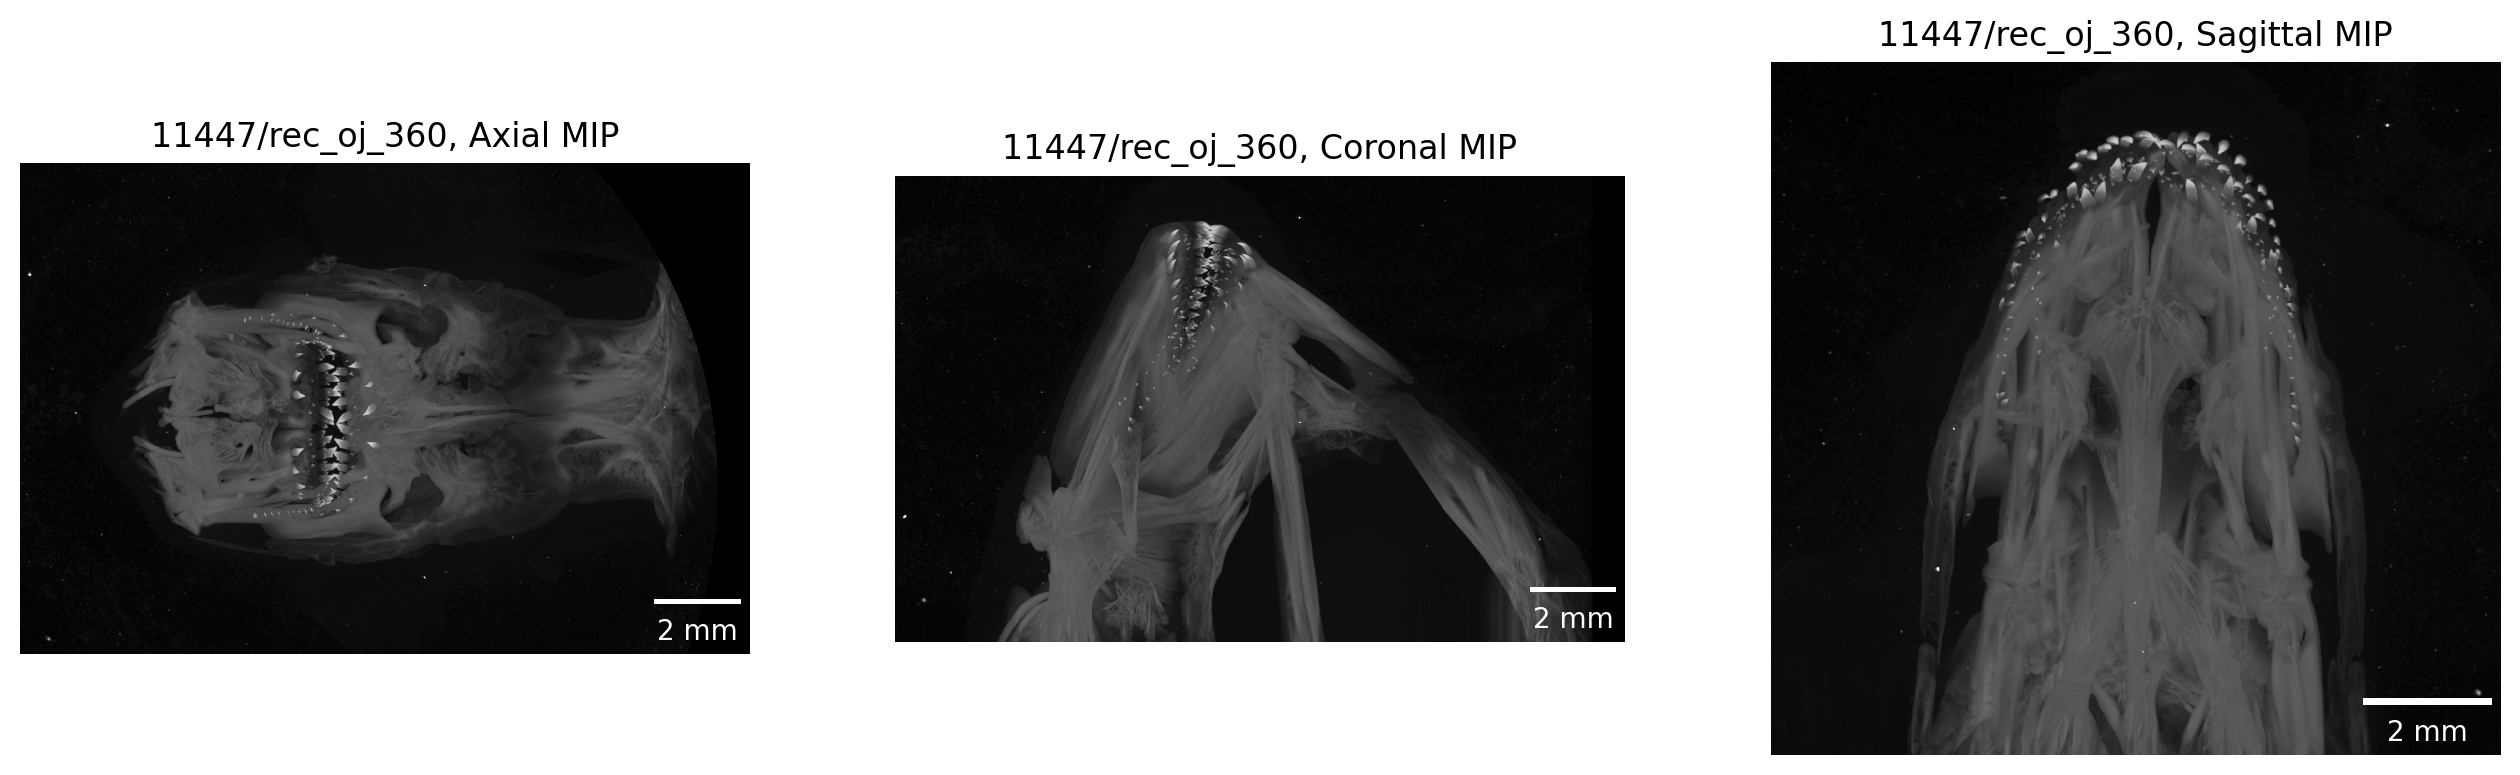

In [70]:
# Show MIP slices
for c, row in tqdm(Data.iterrows(),
                   desc='Saving MIP images overview',
                   total=len(Data),
                   leave=False):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Fish'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in tqdm(enumerate(directions),
                                          desc='%s/%s' % (row['Fish'], row['Scan']),
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction].squeeze())
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s, %s' % (os.path.join(row['Fish'], row['Scan']),
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath,
                    transparent=True,
                    bbox_inches='tight')
        plt.show()

In [ ]:
# Calculate the histograms of one of the MIPs
# Caveat: dask.da.histogram returns histogram AND bins, making each histogram a 'nested' list of [h, b]
Data['Histogram'] = [dask.array.histogram(dask.array.array(mip.squeeze()),
                                          bins=2**8,
                                          range=[0, 2**8]) for mip in Data['MIP_Coronal']]
# Actually compute the data and put only h into the dataframe, since we use it quite often below.
# Discard the bins
Data['Histogram'] = [h for h,b in Data['Histogram']]

In [ ]:
def overeexposecheck(item, threshold=250, howmanypercent=0.1, whichone='Coronal', verbose=False):
    '''Function to check if a certain amount of voxels are brighter than a certain value'''
    if (Data['MIP_%s' % whichone][item]>threshold).sum() > (Data['MIP_Sagittal'][item].size * howmanypercent / 100):
        if verbose:
            plt.imshow(Data['MIP_%s' % whichone][item].squeeze())
            plt.imshow(numpy.ma.masked_equal(Data['MIP_%s' % whichone][item].squeeze()>threshold, False),
                       cmap='viridis_r',
                       alpha=.618)
            plt.title('%s/%s\n%s of %s Mpixels (>%s%%) are brighter '
                      'than %s' % (Data['Fish'][item],
                                   Data['Scan'][item],
                                   (Data['MIP_%s' % whichone][item]>threshold).sum().compute(),
                                   round(1e-6 * Data['MIP_%s' % whichone][item].size,2),
                                   howmanypercent,
                                   threshold))
            plt.axis('off')
            plt.gca().add_artist(ScaleBar(Data['Voxelsize'][item],
                                          'um'))
            plt.show()
        return(True)
    else:
        return(False)    

In [ ]:
# Check if 'too much' of the MIP is overexposed
# TODO: How much is 'too much'?
Data['OverExposed'] = [overeexposecheck(c,
                                        whichone='Coronal',
                                        verbose=True) for c, row in Data.iterrows()]

In [ ]:
for c, row in sorted(Data.iterrows()):
    plt.plot(row.Histogram,
             label='%s/%s' % (row.Fish, row.Scan))
plt.xlim([0, 255])
plt.legend()
plt.show()

In [ ]:
print('At the moment, we have previewed %s scans of %s fishes in %s' % (len(Data),
                                                                        len(Data.Fish.unique()),
                                                                        Root))